In [2]:
%load_ext autoreload
%autoreload 2

from openclem.detectors.demo.demo import DemoDetector
from openclem.structures import DetectorSettings, ImageSettings, SerialSettings
import matplotlib.pyplot as plt

# initialise logging
import logging
logging.basicConfig(level=logging.INFO)


In [3]:
det_settings = DetectorSettings(
    name="demo",
    serial_settings=SerialSettings(
        port="ttyUSB0",
        baudrate=9600,
        timeout=0.1),
    pixel_size=1e-6,
    resolution=[2048, 2048],

)

detector = DemoDetector(detector_settings=det_settings)
detector.init_camera()

INFO:root:Initializing Demo Camera
INFO:root:Initialized Demo Camera: DemoCamera


In [5]:
image_settings = ImageSettings(
    pixel_size=1e-6,
    exposure=1e-3
    )

image = detector.grab_image(image_settings)
print(image.shape)

INFO:root:Grabbing image from Demo Camera
INFO:root:Opening Demo Camera
INFO:root:Setting Demo Camera settings: ImageSettings(pixel_size=1e-06, exposure=0.001, image_format='tiff', trigger_source='software', trigger_edge='rising', exposure_mode='level', timeout=1000, n_images=1)
INFO:root:Closing Demo Camera


(2048, 2048)


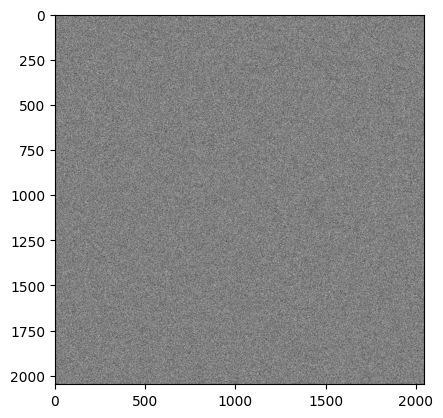

In [7]:
plt.imshow(image, cmap="gray")
plt.show()

## Setup Session


In [6]:
%load_ext autoreload
%autoreload 2

from openclem import utils
from openclem.microscopes.base import BaseLightMicroscope

lc, det, obj = utils.setup_session()

lm: BaseLightMicroscope = utils.create_microscope("test", det, lc, obj)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/patrick/github/openCLEM/openclem/lasers/demo
/home/patrick/github/openCLEM/openclem/lasers/demo
/home/patrick/github/openCLEM/openclem/detectors/demo
/home/patrick/github/openCLEM/openclem/objective_stages/demo
2023-03-29 15:36:56,297 — root — INFO — disable:72 — Disabling laser_1
2023-03-29 15:36:56,298 — root — INFO — disable:72 — Disabling laser_2
2023-03-29 15:36:56,299 — root — INFO — disable:72 — Disabling laser_3
2023-03-29 15:36:56,300 — root — INFO — disable:72 — Disabling laser_4
2023-03-29 15:36:56,301 — root — INFO — connect:94 — Connecting to demo
2023-03-29 15:36:56,303 — root — INFO — connect:96 — Connected to demo
2023-03-29 15:36:56,304 — root — INFO — connect:28 — Connecting to Demo Detector...
2023-03-29 15:36:57,307 — root — INFO — connect:30 — Connected to Demo Detector.


2023-03-29 15:55:55,293 — root — INFO — connect:28 — Connecting to Demo Detector...
2023-03-29 15:55:56,295 — root — INFO — connect:30 — Connected to Demo Detector.
2023-03-29 15:55:56,296 — root — INFO — connect:94 — Connecting to demo
2023-03-29 15:55:56,298 — root — INFO — connect:96 — Connected to demo
2023-03-29 15:55:56,299 — root — INFO — connect:13 — Connecting to demo objective


In [30]:
lm.get_detector()
lm.get_laser_controller()
lm.get_objective()

demo - ObjectiveStage

In [29]:
lm._laser_controller.get_laser("laser_1")


laser_1 - Laser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['../image_00.npy', '../image_01.npy', '../image_02.npy', '../image_03.npy', '../image_04.npy', '../image_05.npy', '../image_06.npy', '../image_07.npy', '../image_08.npy', '../image_09.npy', '../image_10.npy', '../image_11.npy']


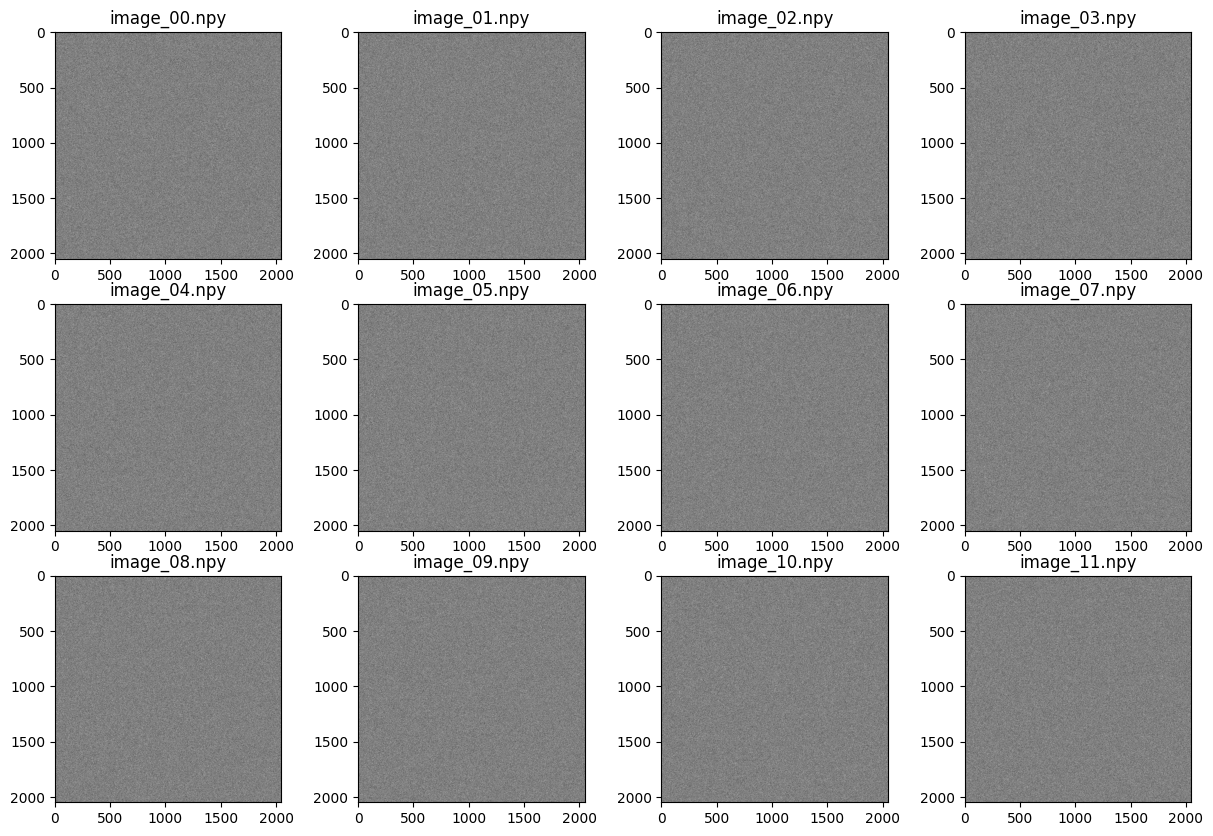

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import glob 
filenames = sorted(glob.glob(r"../image_*.npy"))

print(filenames)
import os

# plot as subplots
fig, axs = plt.subplots(len(filenames)//4, 4, figsize=(15, 10))
for i, fname in enumerate(filenames):
    arr = np.load(fname)
    axs[i//4, i%4].imshow(arr, cmap="gray")
    axs[i//4, i%4].set_title(os.path.basename(fname))

## Light Images

Save / Load

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import glob
import os

import openclem
from openclem.structures import LightImage, LightImageMetadata


filenames = sorted(glob.glob("../*.tif"))

print(filenames)


['..\\2023-04-05-11-00-26AM.tif', '..\\2023-04-05-11-00-27AM.tif', '..\\2023-04-05-11-00-28AM.tif', '..\\2023-04-05-11-00-30AM.tif']


LightImageMetadata(n_channels=3, channels=[0, 2, 3], time=2023-04-05-11-00-26AM, lasers=[LaserSettings(name='laser_1', serial_id=None, wavelength='405.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_2', serial_id=None, wavelength='488.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_3', serial_id=None, wavelength='555.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_4', serial_id=None, wavelength='640.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0])], detector=DetectorSettings(name='demo', serial_settings=None, pixel_size=6.5e-06, resolution=[2048, 2048], trigger_source=<TriggerSource.SOFTWARE: 1>, trigger_edge=<TriggerEdge.RISING: 1>, exposure_mode=<ExposureMode.TRIGGER_WIDTH: 2>, timeout=1000), objective=0.0, image=ImageSettings(pixel_size=2.5e-05, exposure=0.5, image_format='tiff', n_images=4, mode=<ImageMode.LIVE: 'live'>)

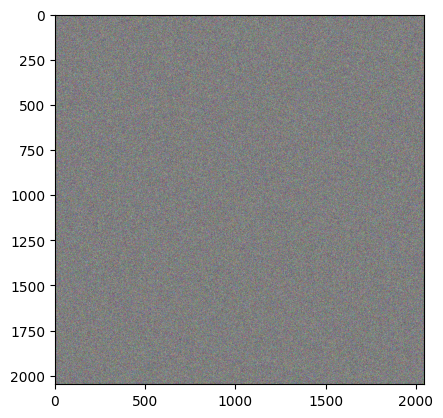

LightImageMetadata(n_channels=3, channels=[0, 2, 3], time=2023-04-05-11-00-27AM, lasers=[LaserSettings(name='laser_1', serial_id=None, wavelength='405.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_2', serial_id=None, wavelength='488.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_3', serial_id=None, wavelength='555.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_4', serial_id=None, wavelength='640.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0])], detector=DetectorSettings(name='demo', serial_settings=None, pixel_size=6.5e-06, resolution=[2048, 2048], trigger_source=<TriggerSource.SOFTWARE: 1>, trigger_edge=<TriggerEdge.RISING: 1>, exposure_mode=<ExposureMode.TRIGGER_WIDTH: 2>, timeout=1000), objective=0.0, image=ImageSettings(pixel_size=2.5e-05, exposure=0.5, image_format='tiff', n_images=4, mode=<ImageMode.LIVE: 'live'>)

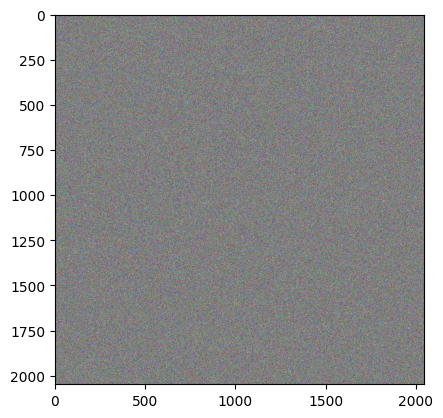

LightImageMetadata(n_channels=3, channels=[0, 2, 3], time=2023-04-05-11-00-28AM, lasers=[LaserSettings(name='laser_1', serial_id=None, wavelength='405.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_2', serial_id=None, wavelength='488.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_3', serial_id=None, wavelength='555.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_4', serial_id=None, wavelength='640.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0])], detector=DetectorSettings(name='demo', serial_settings=None, pixel_size=6.5e-06, resolution=[2048, 2048], trigger_source=<TriggerSource.SOFTWARE: 1>, trigger_edge=<TriggerEdge.RISING: 1>, exposure_mode=<ExposureMode.TRIGGER_WIDTH: 2>, timeout=1000), objective=0.0, image=ImageSettings(pixel_size=2.5e-05, exposure=0.5, image_format='tiff', n_images=4, mode=<ImageMode.LIVE: 'live'>)

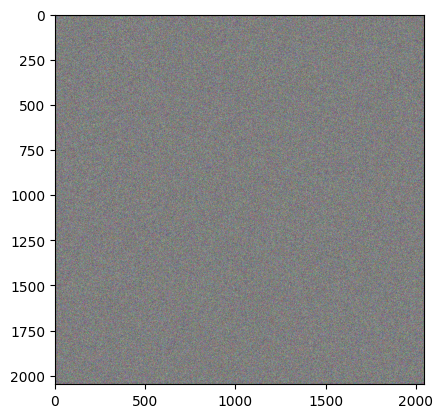

LightImageMetadata(n_channels=3, channels=[0, 2, 3], time=2023-04-05-11-00-30AM, lasers=[LaserSettings(name='laser_1', serial_id=None, wavelength='405.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_2', serial_id=None, wavelength='488.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_3', serial_id=None, wavelength='555.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0]), LaserSettings(name='laser_4', serial_id=None, wavelength='640.0nm', power=4.0, exposure_time=1.0, enabled=False, colour=[0, 0, 0])], detector=DetectorSettings(name='demo', serial_settings=None, pixel_size=6.5e-06, resolution=[2048, 2048], trigger_source=<TriggerSource.SOFTWARE: 1>, trigger_edge=<TriggerEdge.RISING: 1>, exposure_mode=<ExposureMode.TRIGGER_WIDTH: 2>, timeout=1000), objective=0.0, image=ImageSettings(pixel_size=2.5e-05, exposure=0.5, image_format='tiff', n_images=4, mode=<ImageMode.LIVE: 'live'>)

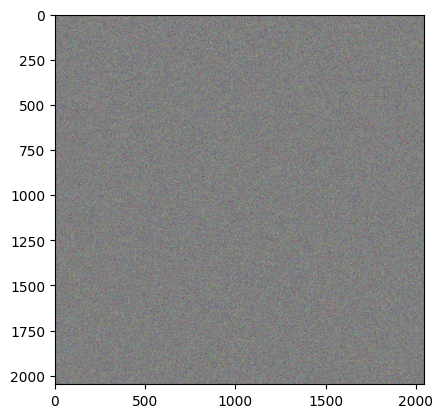

In [9]:
for fname in filenames:
    try:
        image = LightImage.load(fname)

        print(image.metadata)
        plt.imshow(image.data)
        plt.show()
    except Exception as e:
        import traceback
        print(traceback.format_exc())